<a href="https://colab.research.google.com/github/Pager07/FinalYearProject/blob/master/CourtSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project LadderBoard
- Imports (DONE)
- Viewing Data (DONE)
  - Images (DONE)
  - Mask (DONE)
- Load codes files (DONE)
- Write function to load the mask (DONE)
- Create DataSet 
- Create Dataloader 
- Create Model
  - 

#Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from google.colab import drive

In [2]:
drive.mount('/content/gdrive' , force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Understanding the data

In [0]:
root_dir =  '/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4'
path = Path(root_dir)

In [0]:
path_lbl = path/'Labels'
path_img = path/'Image'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-6 screenshot.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-11 screenshot.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-23 screenshot.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-6 screenshot_mask.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-7 screenshot_mask.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-7 screenshot (1)_mask.png')]

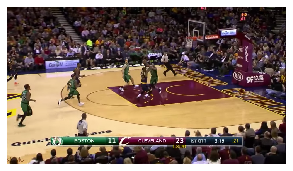

In [7]:
img_f  = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask{x.suffix}'

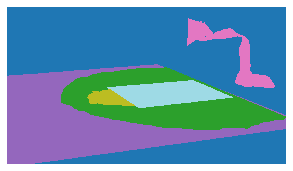

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5) , alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[0, 0, 2,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 2, 2,  ..., 0, 0, 0],
          [0, 2, 2,  ..., 0, 0, 0],
          [0, 2, 2,  ..., 0, 0, 0]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Other', '2Point', '3Point', 'Board', 'Freethrow', 'Layup'], dtype='<U9')

#Creating DataObject,Dataloader and Databunch

In [0]:
src_size = 360

In [0]:
size = src_size
free  = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free") 

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.3)
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms() , size= src_size, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

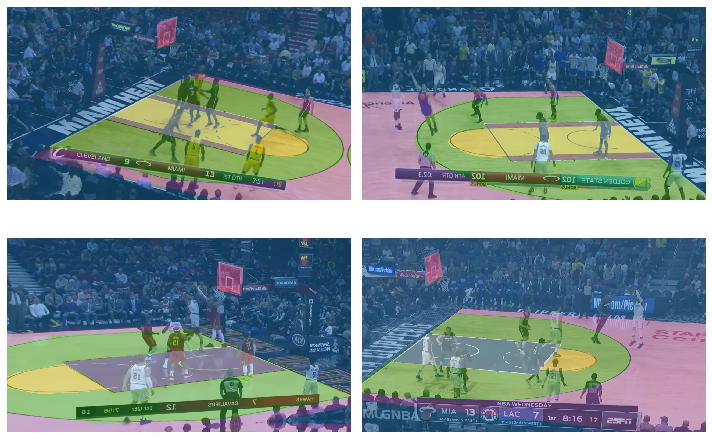

In [0]:
data.show_batch(2,figsize=(10,7))

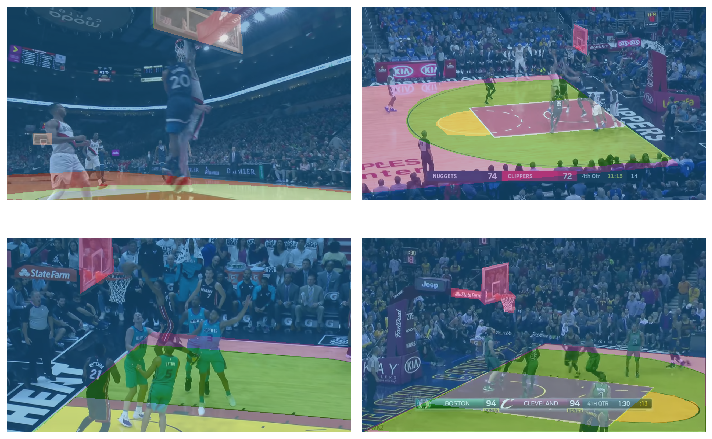

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

#Building the model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Other']

def acc_courtSeg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# def dice(pred, targs):
#    pred = (pred>0).float()
#    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [0]:
metrics = acc_courtSeg

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_courtSeg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


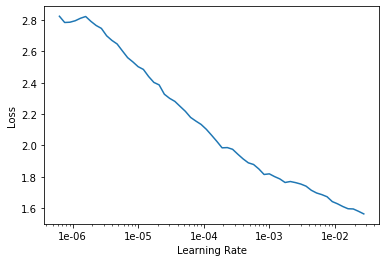

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-4

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,1.065944,0.997166,0.379286,00:26
1,0.826907,1.136261,0.243971,00:26
2,0.706280,0.736506,0.567766,00:26
3,0.651170,0.798317,0.454266,00:26
4,0.644594,0.622198,0.605913,00:26
5,0.588684,0.533103,0.651765,00:26
6,0.575567,0.601424,0.574684,00:26
7,0.490504,0.551573,0.747488,00:26
8,0.471022,0.597348,0.681400,00:26
9,0.301472,0.407467,0.803063,00:27


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

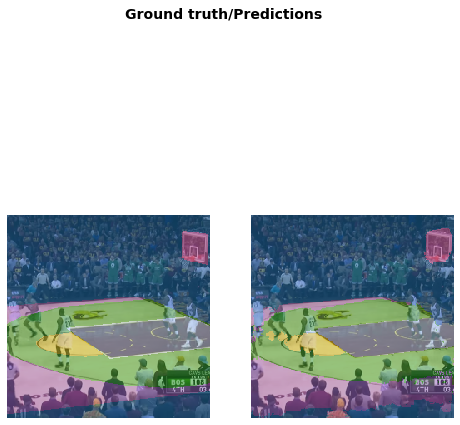

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,0.269520,0.424345,0.787858,00:27
1,0.260981,0.405738,0.796088,00:27
2,0.252825,0.450134,0.785381,00:27
3,0.285813,0.433595,0.793850,00:27
4,0.251945,0.416286,0.799752,00:27
5,0.216979,0.466795,0.801353,00:27
6,0.256548,0.509963,0.755634,00:27
7,0.242796,0.432508,0.810514,00:27
8,0.244680,0.724542,0.751049,00:27
9,0.189513,0.436689,0.841577,00:28


In [0]:
learn.save('stage-2');

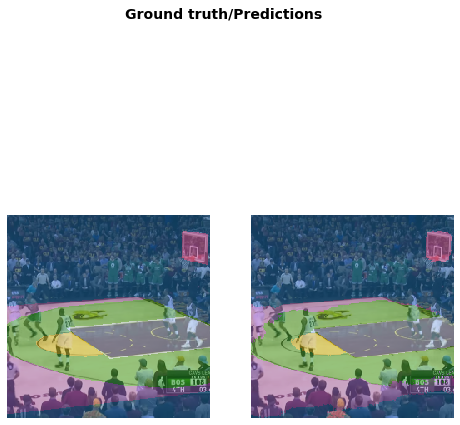

In [0]:
learn.show_results(rows=3, figsize=(8,9))

#FitOneCycle ImageSize 360x360

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,0.991092,0.839864,0.372602,01:39
1,0.835444,0.726735,0.507024,00:29
2,0.691629,0.773833,0.524621,00:29
3,0.707849,0.635175,0.565471,00:29
4,0.633473,0.516190,0.561633,00:29
5,0.689717,0.561128,0.605380,00:29
6,0.661428,0.525425,0.623753,00:29
7,0.567298,0.557908,0.733540,00:29
8,0.451498,0.438120,0.701300,00:29
9,0.350673,0.330643,0.798991,00:29


In [0]:
learn.save('stage-1-imgsize360')

In [0]:
learn.load('stage-1');

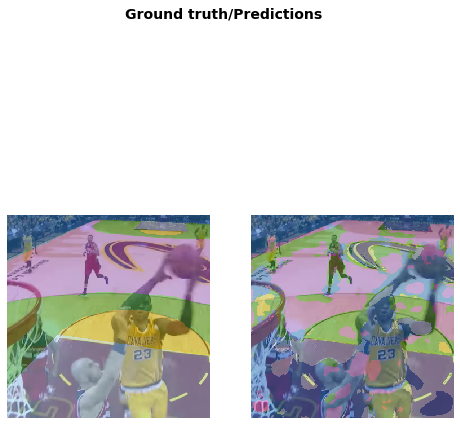

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,0.393799,0.342378,0.775841,00:30
1,0.349463,0.327456,0.791418,00:30
2,0.358810,0.323862,0.785567,00:30
3,0.342626,0.329030,0.792482,00:30
4,0.309761,0.328183,0.767174,00:30
5,0.292352,0.316450,0.787672,00:30
6,0.304003,0.311224,0.805544,00:30
7,0.281959,0.327430,0.800498,00:31
8,0.317052,0.342652,0.752270,00:30
9,0.216737,0.325192,0.797286,00:30


In [0]:
learn.save('stage-2-imgsize360');

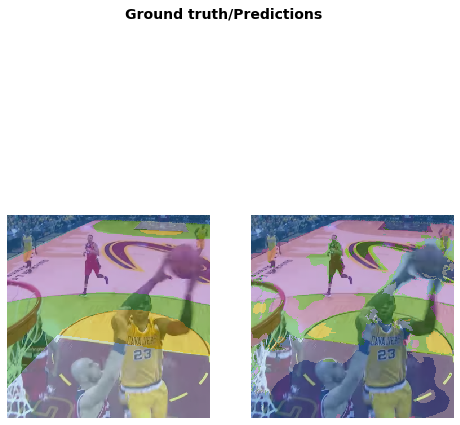

In [0]:
learn.show_results(rows=3, figsize=(8,9))

#Training On Src Size using weigths of smaller images

In [13]:
size = src_size
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 7601MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(),size=size , tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.load("stage-2");

In [22]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_courtSeg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


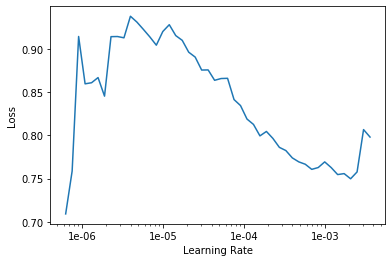

In [24]:
learn.recorder.plot()

In [0]:
lr=1e-4

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,0.591259,0.598113,0.560103,03:20
1,0.509540,0.526805,0.619116,02:54
2,0.424371,0.455257,0.674567,02:55
3,0.374517,0.424591,0.729172,02:55
4,0.340800,0.407127,0.732914,02:55
5,0.305261,0.407025,0.743786,02:55
6,0.257660,0.484557,0.784350,02:55
7,0.208359,0.361544,0.805847,02:55
8,0.242663,0.328968,0.824655,02:55
9,0.174717,0.326496,0.809778,02:55


In [0]:
learn.save('stage-1-big')

In [29]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (188 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image;

Valid: LabelList (80 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=Fa

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-7,lr/10)

In [33]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,0.167358,0.318880,0.821333,03:01
1,0.171996,0.322137,0.820235,03:03
2,0.184548,0.314946,0.812833,03:04
3,0.161904,0.324102,0.815068,03:03
4,0.142151,0.330197,0.813732,03:04
5,0.140551,0.330360,0.819759,03:03
6,0.155138,0.329846,0.815200,03:03
7,0.148110,0.322926,0.816680,03:03
8,0.142767,0.329214,0.813247,03:03
9,0.143154,0.324989,0.820591,03:03


In [0]:
learn.save('stage-2-big')

In [36]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (188 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image;

Valid: LabelList (80 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=Fa

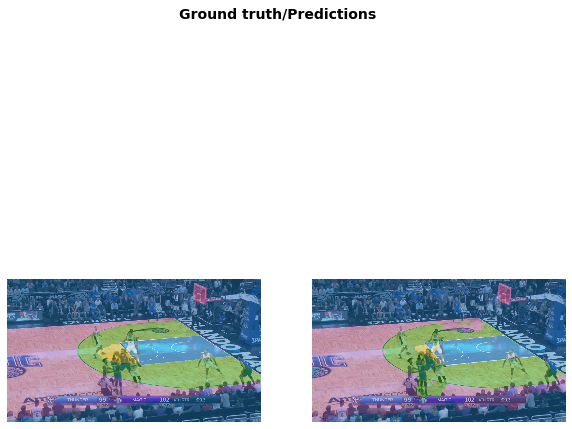

In [41]:
learn.show_results(rows=4,figsize=(10,10))